# Question 1
## Implement the forward pass of Convolutional Neural Network

#### Implementation Details:
1. The convolutional neural network is modeled in a class called 'Convolutional_Neural_Network' It has all the functions required fot the forward pass which will be described later.
2. Any size input image can be provided as input that will automatically be resized to the specified size (here 32x32).
3. The covolution and pooling functions are flixible enough to handle different filter sizes and strides.
4. The filter sizes and strides are defined when initializing an object of the class.
5. Activation functions available are relu, softmax, sigmoid and tanh. Activation function relu is used in all the convolutional and hidden layers and softmax is used for the output layer.
6. PIL library is used for image pre-processing and displaying.

In [104]:
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
import copy

# This function is used for displaying a list of numpy images. We show output of each layer.
def show_images(images, cols=1, titles=None, axis=True):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None:
        titles = ['Image %d' % i for i in range(1, n_images + 1)]
    fig = plt.figure(figsize=(18,5))
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        try:
            if image.ndim == 2:
                plt.gray()
        except:
            pass
        plt.imshow(image)
        if axis == False:
            plt.axis('off')
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

#### The Convolutional_Neural_Network class has the following functions:
1. **\__init\__**: Initializes the convolutional neural network with specified filter sizes and strides.  
2. **read_image**: Given the image path and image dimensions, it reads the image from the path and resizes the image to the specified dimensions.
3. **convolution**: Performs convolution between an image and a filter with a specified stride and returns the output.
4. **pooling**: Performs max-pooling of an image with specified filter stride and size and returns the output.
5. **forward**: Performs the forward pass of network as required. The code for forward passing of each layer is specified separately inside the function. After each layer we print the output images and the dimensions of the output. After the forward pass is completed, a histogram of output probabilities is plotted.

In [170]:
class Convolutional_Neural_Network:
    
    def __init__(self, conv_filter_size, conv_stride, pool_filter_size, pool_stride):
        self.conv_filter_size = conv_filter_size
        self.pool_filter_size = pool_filter_size
        self.conv_stride = conv_stride
        self.pool_stride = pool_stride
    
    
    def read_image(self, image_path, input_dims, normalize=False):
        self.input_dims = input_dims
        self.image = Image.open(image_path)
        self.image = self.image.resize(self.input_dims, Image.ANTIALIAS)
        self.image = np.array( self.image )
        if normalize:
            self.image = (self.image - self.image.mean()) / self.image.std()
        print 'Input image shape:', self.image.shape
        self.image_dims = self.image.shape
        
        
    def convolution(self, Input, filtr, stride):
        w, h, n = Input.shape
        f_w, f_h, n, f_count = filtr.shape
        result_dim0 = int( (w - f_w) / stride ) + 1
        result_dim1 = int( (h - f_h) / stride ) + 1
        result = np.zeros( (result_dim0, result_dim1, f_count), dtype=np.double )
        for f in range(f_count):
            temp0 = 0
            for dim0 in range(result_dim0):
                temp1 = 0
                for dim1 in range(result_dim1):
                    result[dim0][dim1][f] = np.sum( np.multiply(filtr[:,:,:,f], Input[temp0:temp0+f_w, temp1:temp1+f_h, :]) )
                    temp1 += stride
                temp0 += stride
        return result
    
    
    def pooling(self, Input, filter_size, stride):
        w, h, n = Input.shape
        result_dim0 = int( (w - filter_size) / stride ) + 1
        result_dim1 = int( (h - filter_size) / stride ) + 1
        result = np.zeros( (result_dim0, result_dim1, n), dtype=np.double )

        for ic in range(n):
            temp0 = 0
            for dim0 in range(result_dim0):
                temp1 = 0
                for dim1 in range(result_dim1):
                    result[dim0][dim1][ic] = np.max( Input[temp0:temp0+filter_size, temp1:temp1+filter_size, ic] )
                    temp1 += stride
                temp0 += stride
        return result
    
    
    # Activation Functions
    def sigmoid(z):
        return 1.0 / (1 + np.exp(-z))
    
    def tanh(z):
        return np.tanh(z)
    
    def relu(Input):
        ret = copy.deepcopy(Input)
        ret[ret < 0] = 0
        return ret
    
    def softmax(z):
        e_z = np.exp( z - z.max(1).reshape(z.shape[0],1) )
        return  ( e_z / np.sum(e_z,1).reshape(z.shape[0],1) )
        
    
    def forward(self, conv_activation, hidden_activation, output_activation):
        
        images = []
        images.append(self.image)
        show_images(images, titles=['Input Image'])
        
        ############################## 1. Convolution ##############################
        print '\n1. Convolution'
        filter_size = (self.conv_filter_size, self.conv_filter_size)
        input_channels = 3
        output_channels = 6
        
        Filter = np.random.randn(filter_size[0], filter_size[1], input_channels, output_channels)
        C1 = self.convolution(self.image, Filter, self.conv_stride)
        C1 = self.activations[conv_activation](C1)
        print 'Output image shape:',C1.shape
        
        images = []
        for i in range(output_channels):
            img = Image.fromarray(C1[:,:,i])
            images.append( np.array(img) )
        show_images(images)
        ############################################################################

        
        
        ############################### 2. Pooling #################################
        print '\n2. Pooling'
        S2 = self.pooling(C1, self.pool_filter_size, self.pool_stride)
        print 'Output image shape:',S2.shape
        
        images = []
        for i in range(output_channels):
            img = Image.fromarray(S2[:,:,i])
            images.append( np.array(img) )
        show_images(images)
        ############################################################################

        
        
        ############################## 3. Convolution ##############################
        print '\n3. Convolution'
        filter_size = (self.conv_filter_size, self.conv_filter_size)
        input_channels = 6
        output_channels = 16
        
        Filter = np.random.randn(filter_size[0], filter_size[1], input_channels, output_channels)
        C3 = self.convolution(S2, Filter, self.conv_stride)
        C3 = self.activations[conv_activation](C3)
        print 'Output image shape:',C3.shape
        
        images = []
        for i in range(output_channels):
            img = Image.fromarray(C3[:,:,i])
            images.append( np.array(img) )
        show_images(images)
        ############################################################################
        
        

        ################################ 4. Pooling ################################
        print '\n4. Pooling'
        S4 = cnn.pooling(C3, self.pool_filter_size, self.pool_stride)
        print 'Output image shape:',S4.shape
        
        images = []
        for i in range(output_channels):
            img = Image.fromarray(S4[:,:,i])
            images.append( np.array(img) )
        show_images(images)
        ############################################################################
        
        
        
        ############################## 5. Convolution ##############################
        print '\n5. Convolution'
        filter_size = (self.conv_filter_size, self.conv_filter_size)
        input_channels = 16
        output_channels = 120
        
        Filter = np.random.randn(filter_size[0], filter_size[1], input_channels, output_channels)
        C5 = self.convolution(S4, Filter, self.conv_stride)
        C5 = self.activations[conv_activation](C5)
        print 'Output image shape:',C5.shape
        C5 = C5.reshape(1,output_channels)
        
        images = []
        img = Image.fromarray(C5)
        images.append(img)
        show_images(images, titles=['Flattened Output'])
        ############################################################################
        
        
        
        ############################ 6. Full Connection ############################
        print '\n6. Full Connection'
        inputs = 120
        outputs = 84
        print 'Output image shape:',outputs
        
        W = np.random.randn(inputs, outputs) * math.sqrt(2.0/inputs)
        Z = np.dot(C5,W)
        F6 = self.activations[hidden_activation](Z)
        
        images = []
        img = Image.fromarray(F6)
        images.append(img)
        show_images(images, titles=['Hidden Layer'])
        ############################################################################
        
        
        
        ############################### 7. Output ##################################
        print '\n7. Output'
        inputs = 84
        outputs = 10
        print 'Number of output classes:', outputs
        
        W = np.random.randn(inputs, outputs) * math.sqrt(2.0/inputs)
        Z = np.dot(F6, W)
        
        yHat = self.activations[output_activation](Z)
        
        x = range(10)
        plt.bar(x, height=yHat.reshape(10))
        plt.xticks(x, x)
        plt.xlabel('classes')
        plt.ylabel('probabilities')
        plt.title('Histogram of output probabilities')
        plt.show()
        ############################################################################
    
        return yHat
    
    
    # Set of activation functions available
    activations ={'sigmoid': sigmoid,
                 'relu': relu,
                 'tanh': tanh,
                 'softmax': softmax
                 }

Below we initialize the parameters of the CNN and instantiate an object of the class. Then we read the image and finally do the forward pass and print the predicted class.

Input image shape: (32, 32, 3)


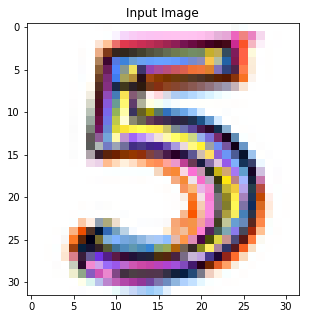


1. Convolution
Output image shape: (28, 28, 6)


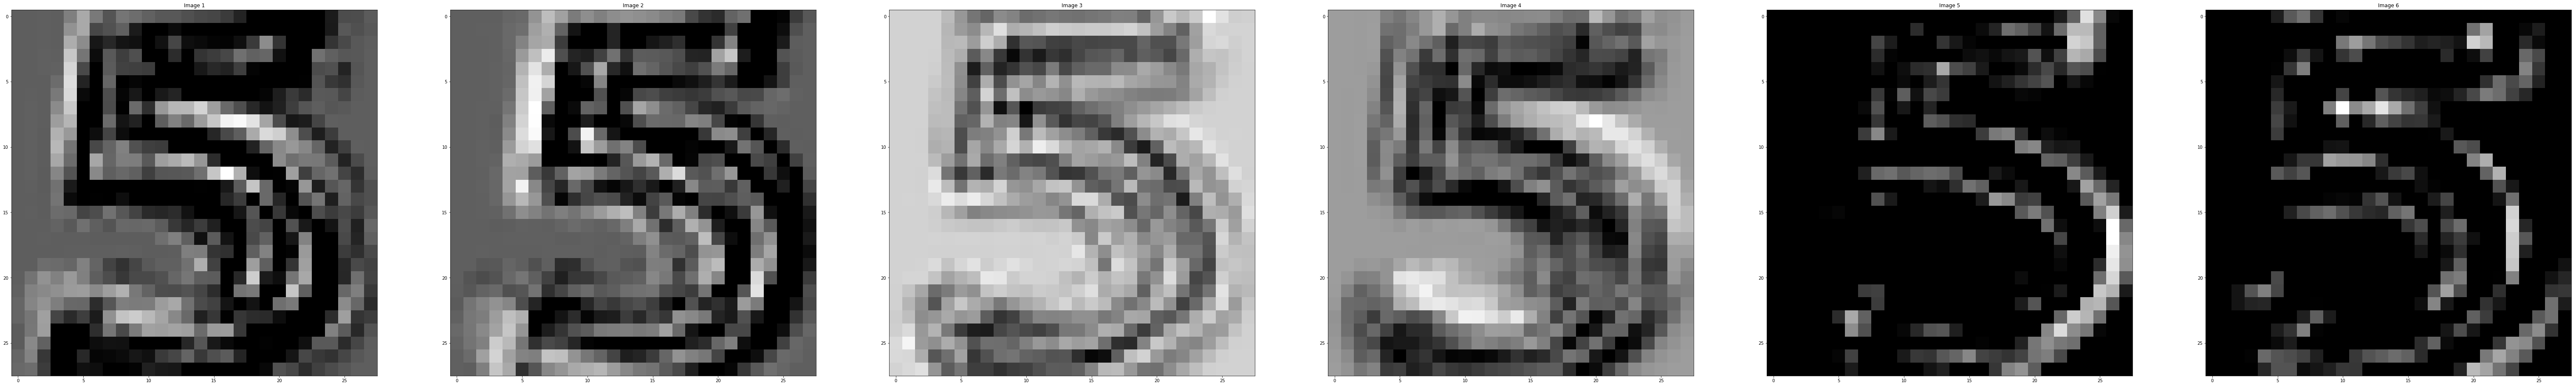


2. Pooling
Output image shape: (14, 14, 6)


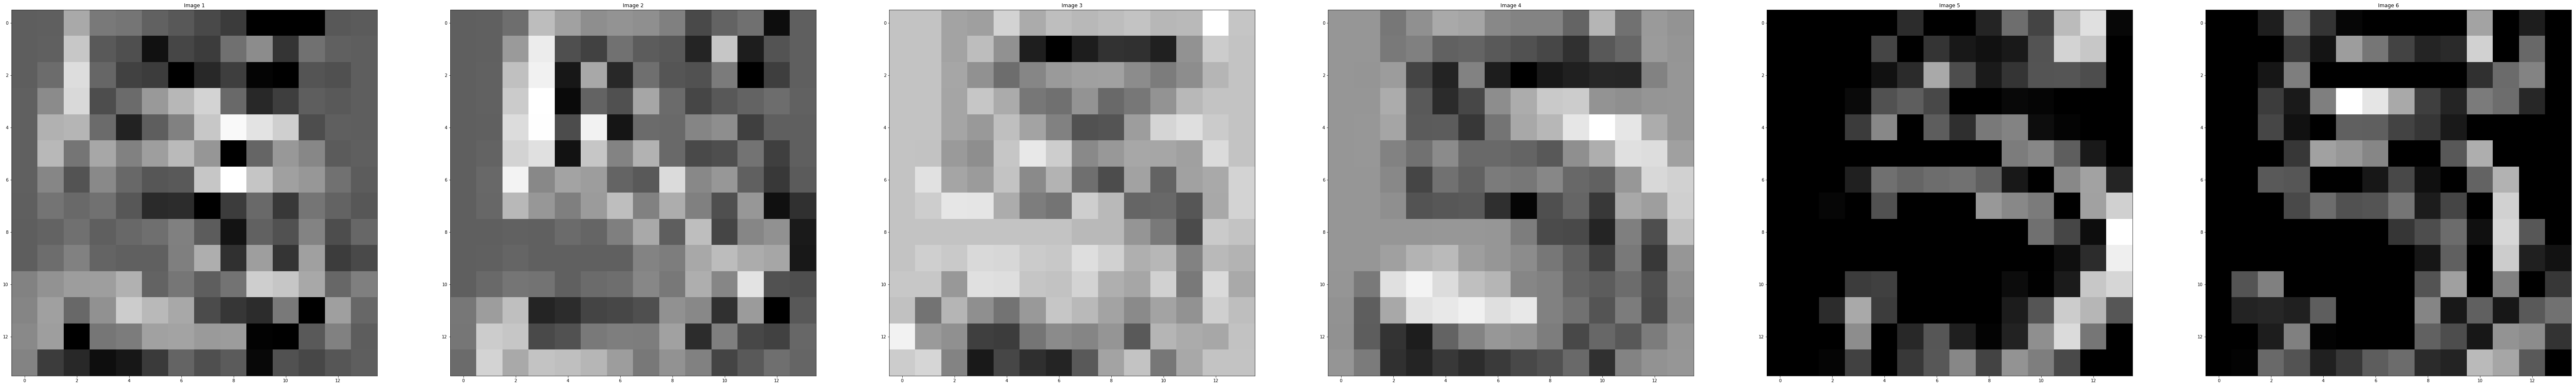


3. Convolution
Output image shape: (10, 10, 16)


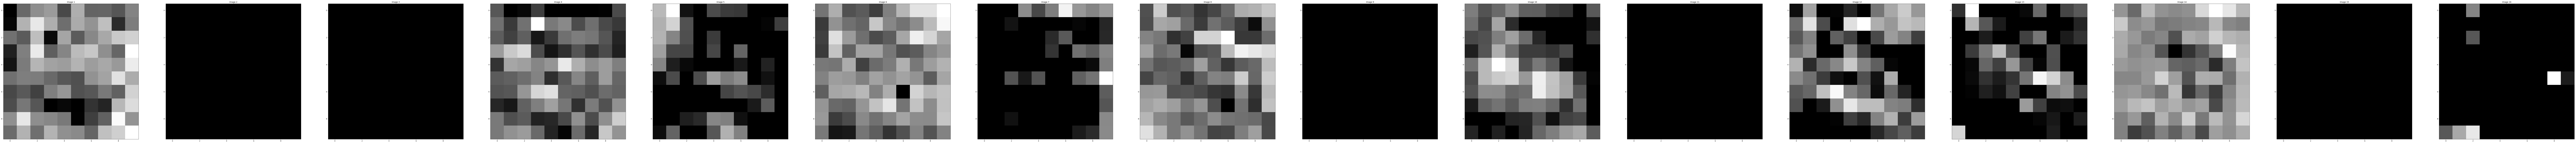


4. Pooling
Output image shape: (5, 5, 16)


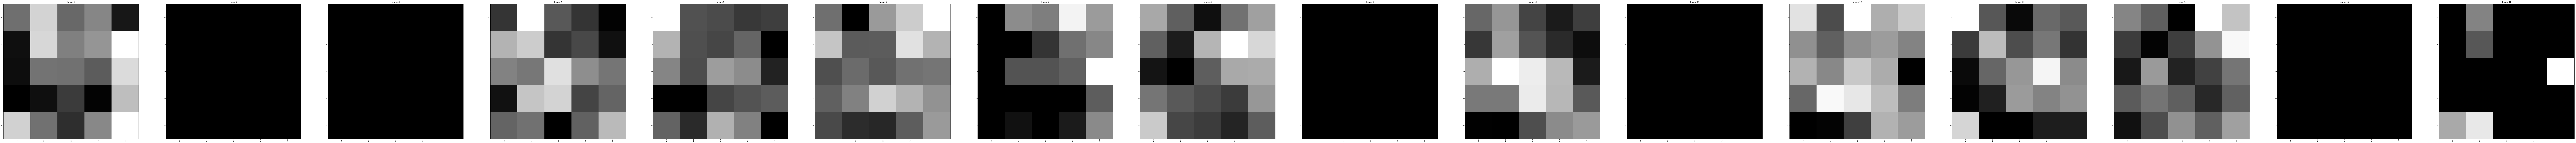


5. Convolution
Output image shape: (1, 1, 120)


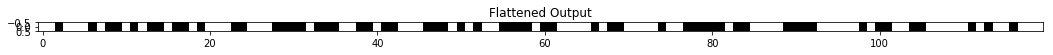


6. Full Connection
Output image shape: 84


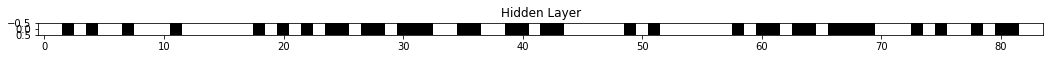


7. Output
Number of output classes: 10


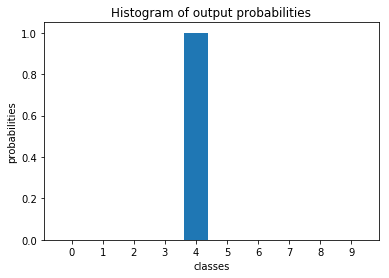



Predicted Class: 4


In [119]:
CONV_filter_size = 5
CONV_stride = 1
POOL_filter_size = 2
POOL_stride = 2
image_path = './input.jpg'
image_dimensions = (32,32)
conv_activation = 'relu'
hidden_activation = 'relu'
output_activation = 'softmax'

cnn = Convolutional_Neural_Network( CONV_filter_size, CONV_stride, POOL_filter_size, POOL_stride )

cnn.read_image(image_path, image_dimensions)

yHat = cnn.forward(conv_activation, hidden_activation, output_activation)

print '\n\nPredicted Class:', np.argmax(yHat)

#### Observations:
1. After convolution, we get different images with lot of fifferent intensity values as we used relu.
2. The output is always biased towards a specific class.
<br> <br>

# Question 2
## Answer the following questions for above architecture:

### 1. What are the number of parameters in 1st convolutional layers ?
Number of parameters in 1st convolutional layers = Size of filter * Number of channels = ((5 * 5 * 3)) * 6 = 450 <br>

### 2. What are the number of parameters in pooling operation?
There are no parameters you could learn in pooling layer. This layer is just used to reduce the image dimensions. <br>

### 3. Which of the following operations contain most number of parameters? <br> (a) conv  (b) pool  (c) Fully connected layer (FC)  (d) Activation Functions
Fully Connected Layer contains the most number of parameters because it was large number of weights due to dense connections.

### 4. Which operation consume most amount of memory? <br> (a) initial convolution layers  (b) fully connected layers at the end
Initial convolution layers consume most amount of memory in CNN because image dimensions are high at initial layers which are flattened later.

### 5. Try different activation functions and describe observations.

Input image shape: (32, 32, 3)


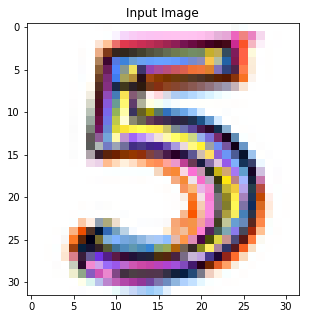


1. Convolution
Output image shape: (28, 28, 6)


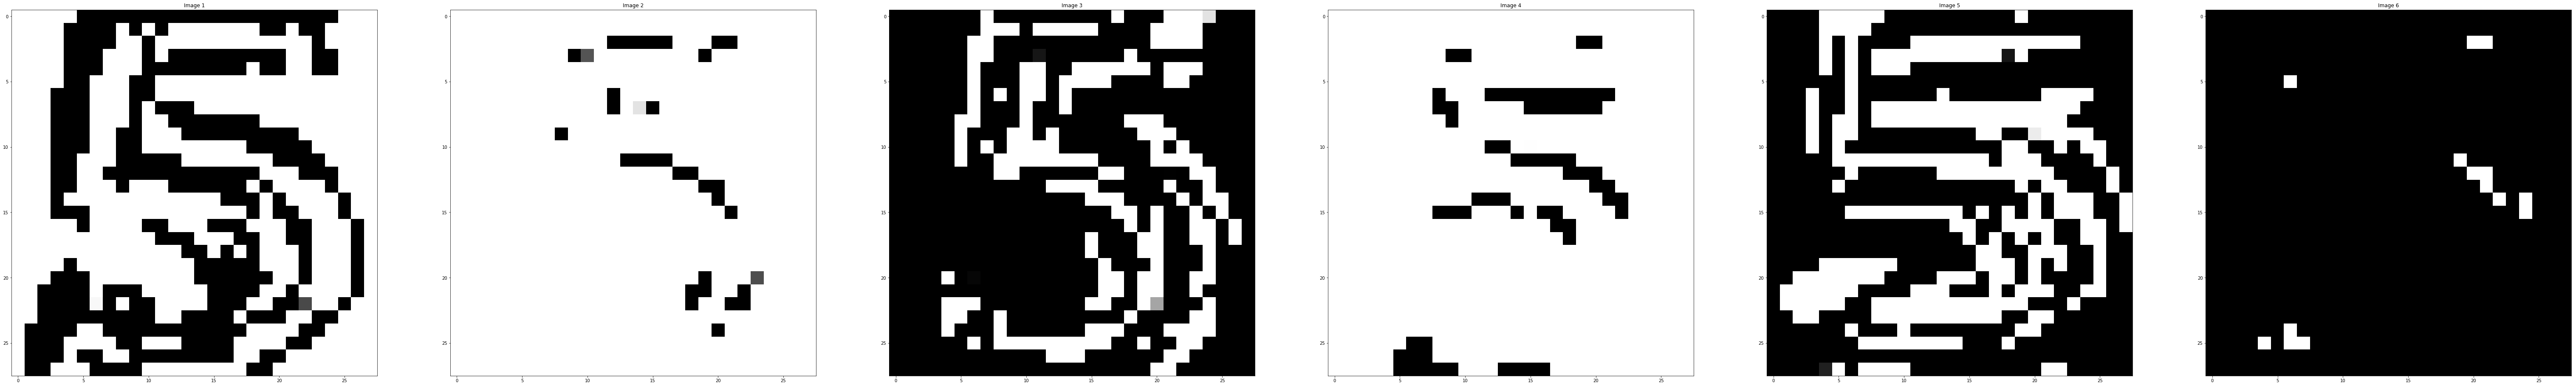


2. Pooling
Output image shape: (14, 14, 6)


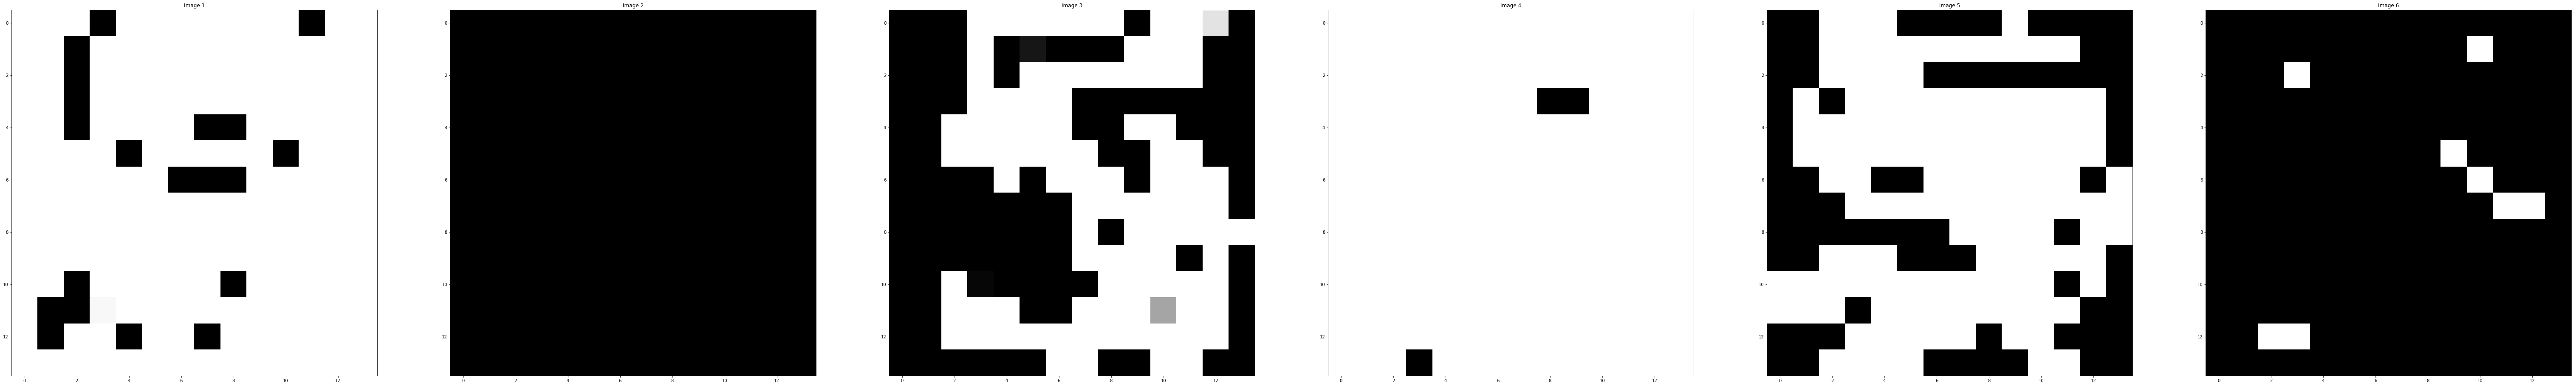


3. Convolution
Output image shape: (10, 10, 16)


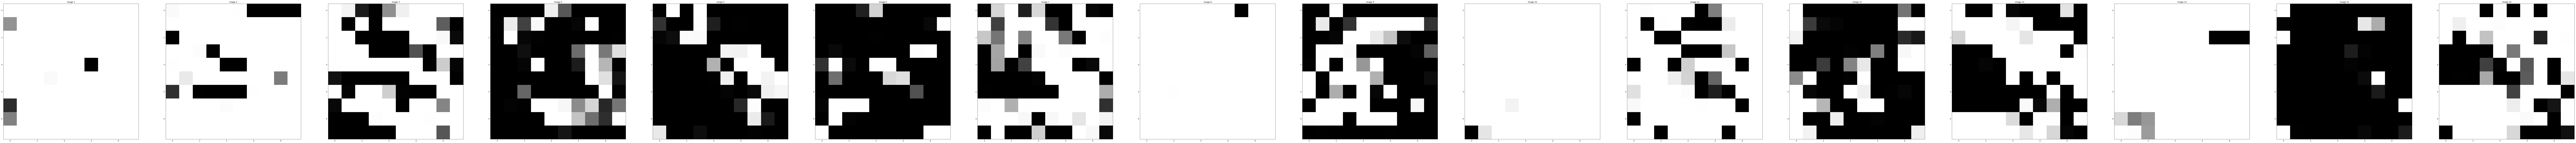


4. Pooling
Output image shape: (5, 5, 16)


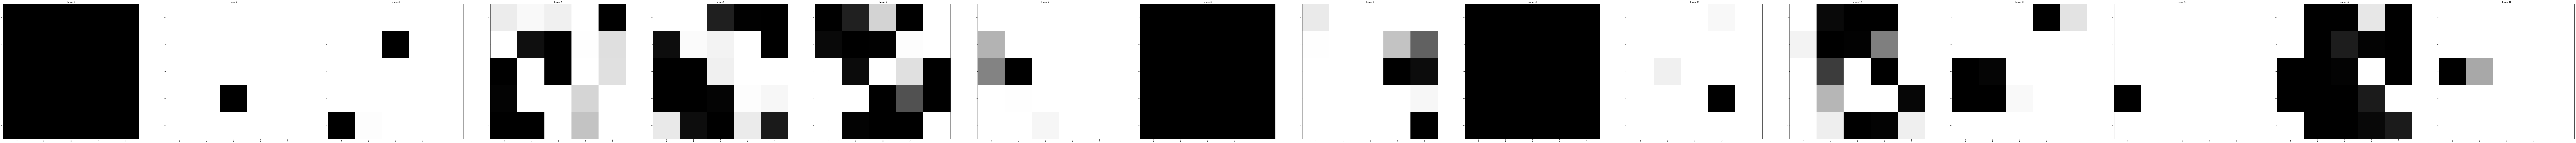


5. Convolution
Output image shape: (1, 1, 120)


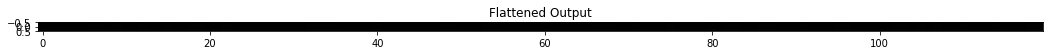


6. Full Connection
Output image shape: 84


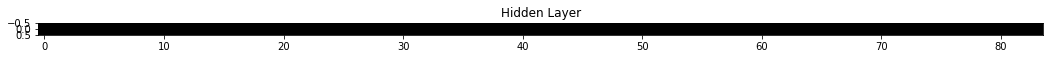


7. Output
Number of output classes: 10


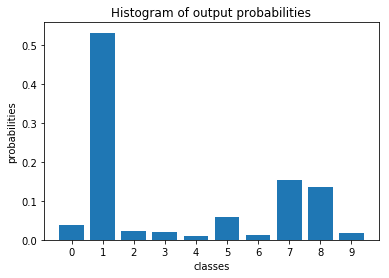



Predicted Class: 1


In [135]:
conv_activation = 'tanh'
hidden_activation = 'tanh'
output_activation = 'softmax'

cnn_ = Convolutional_Neural_Network( CONV_filter_size, CONV_stride, POOL_filter_size, POOL_stride )

cnn_.read_image(image_path, image_dimensions)

yHat = cnn_.forward(conv_activation, hidden_activation, output_activation)

print '\n\nPredicted Class:', np.argmax(yHat)

Input image shape: (32, 32, 3)


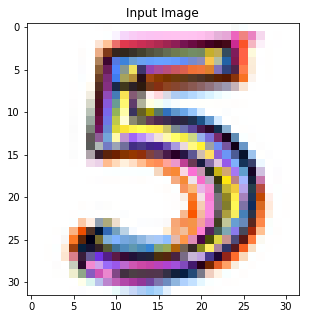


1. Convolution
Output image shape: (28, 28, 6)


/home/devesh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in exp


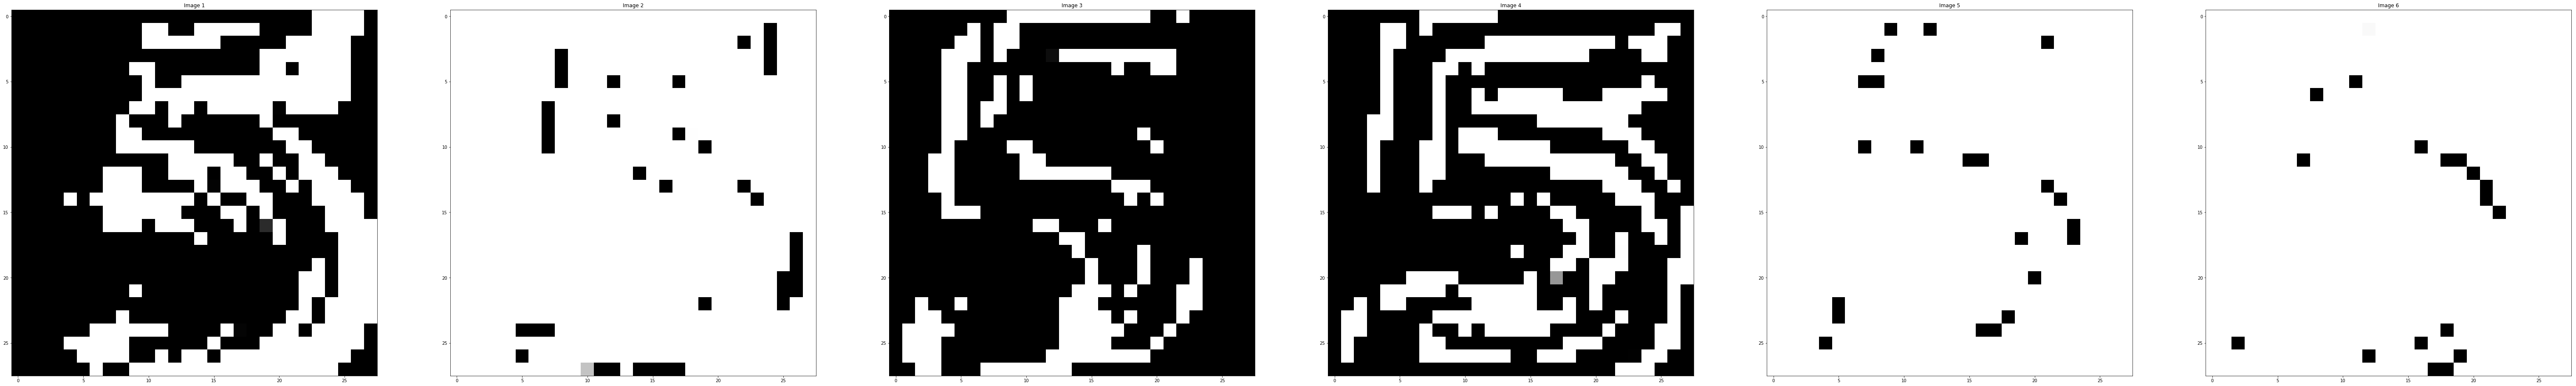


2. Pooling
Output image shape: (14, 14, 6)


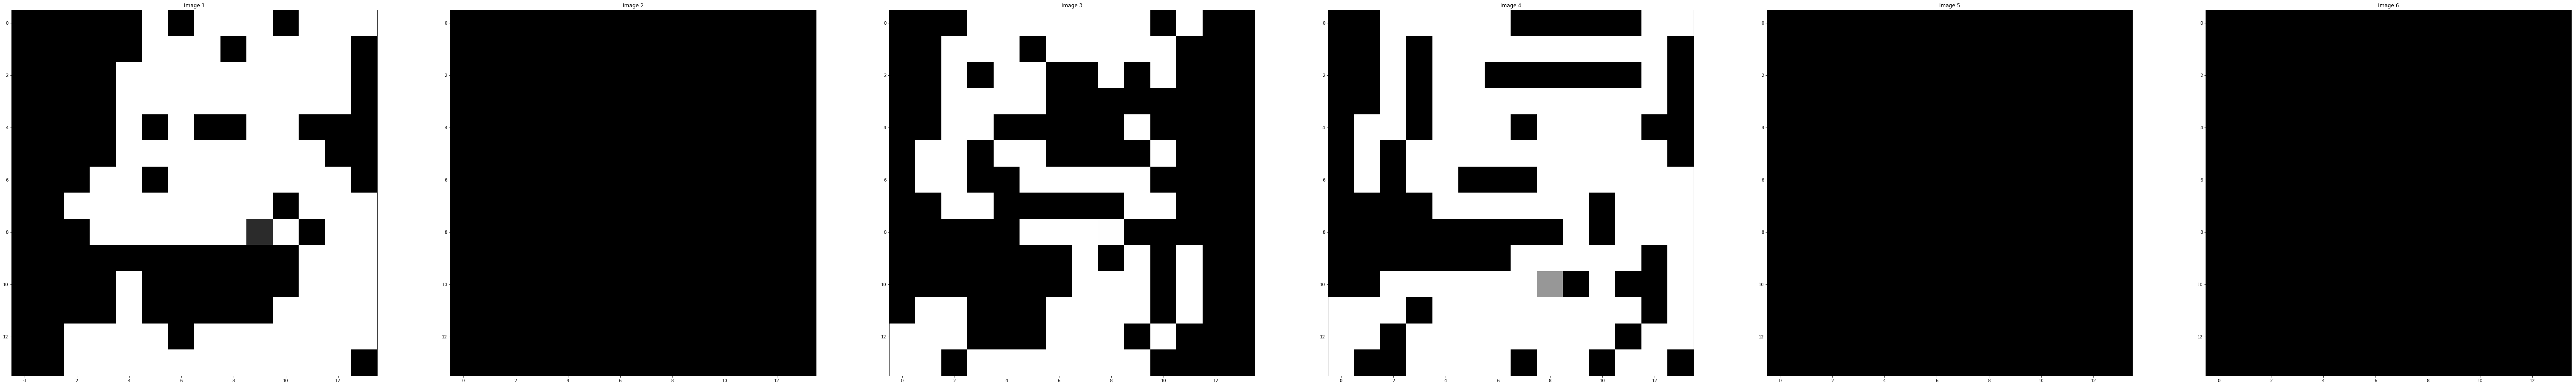


3. Convolution
Output image shape: (10, 10, 16)


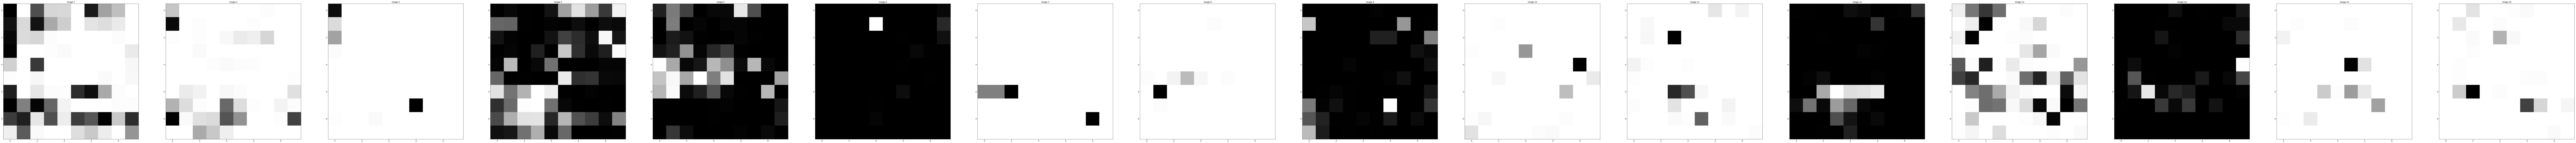


4. Pooling
Output image shape: (5, 5, 16)


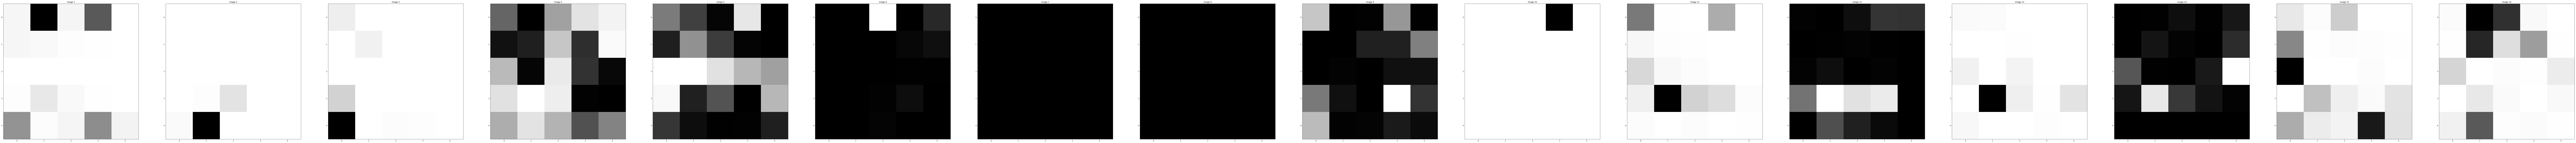


5. Convolution
Output image shape: (1, 1, 120)


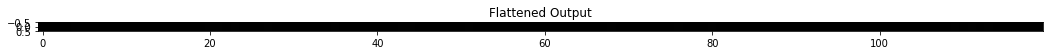


6. Full Connection
Output image shape: 84


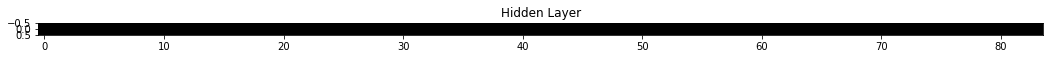


7. Output
Number of output classes: 10


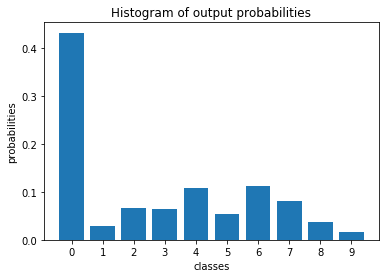



Predicted Class: 0


In [168]:
conv_activation = 'sigmoid'
hidden_activation = 'sigmoid'
output_activation = 'softmax'

cnn_ = Convolutional_Neural_Network( CONV_filter_size, CONV_stride, POOL_filter_size, POOL_stride )

cnn_.read_image(image_path, image_dimensions)

yHat = cnn_.forward(conv_activation, hidden_activation, output_activation)

print '\n\nPredicted Class:', np.argmax(yHat)

Input image shape: (32, 32, 3)


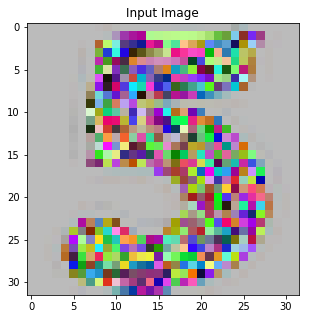


1. Convolution
Output image shape: (28, 28, 6)


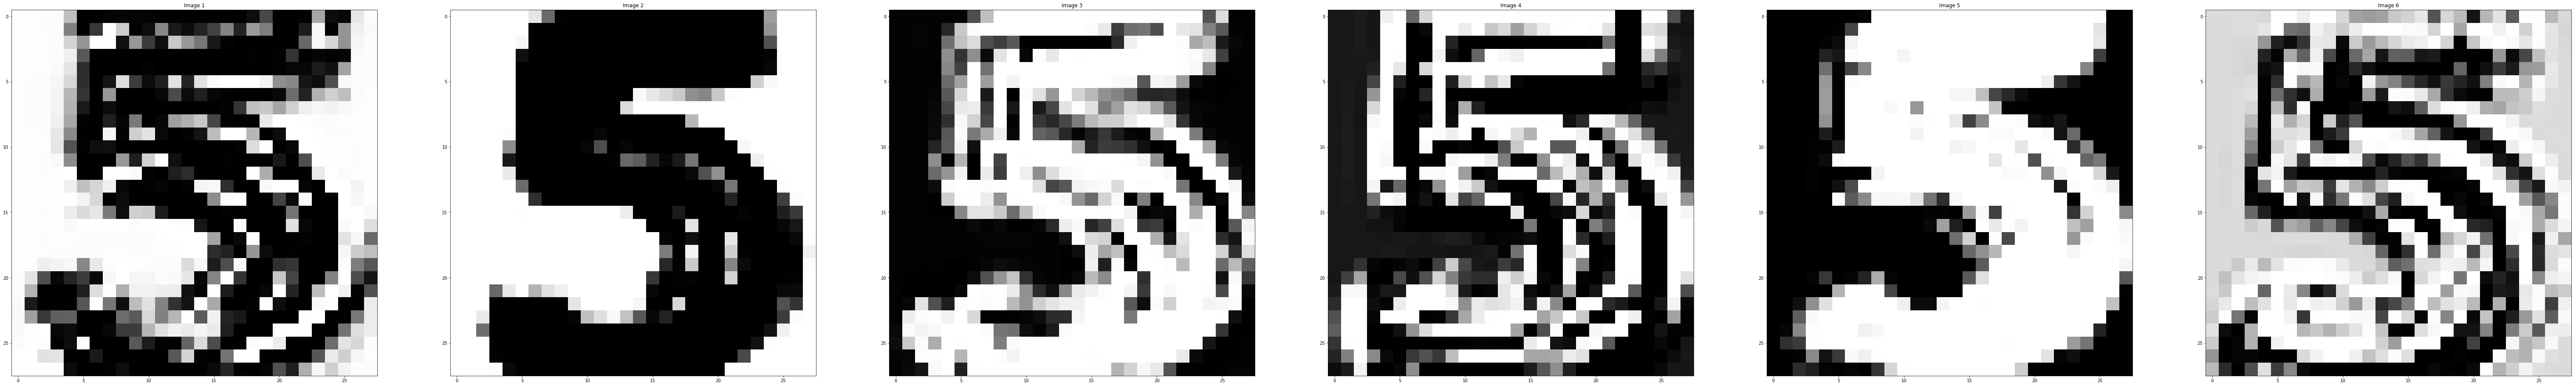


2. Pooling
Output image shape: (14, 14, 6)


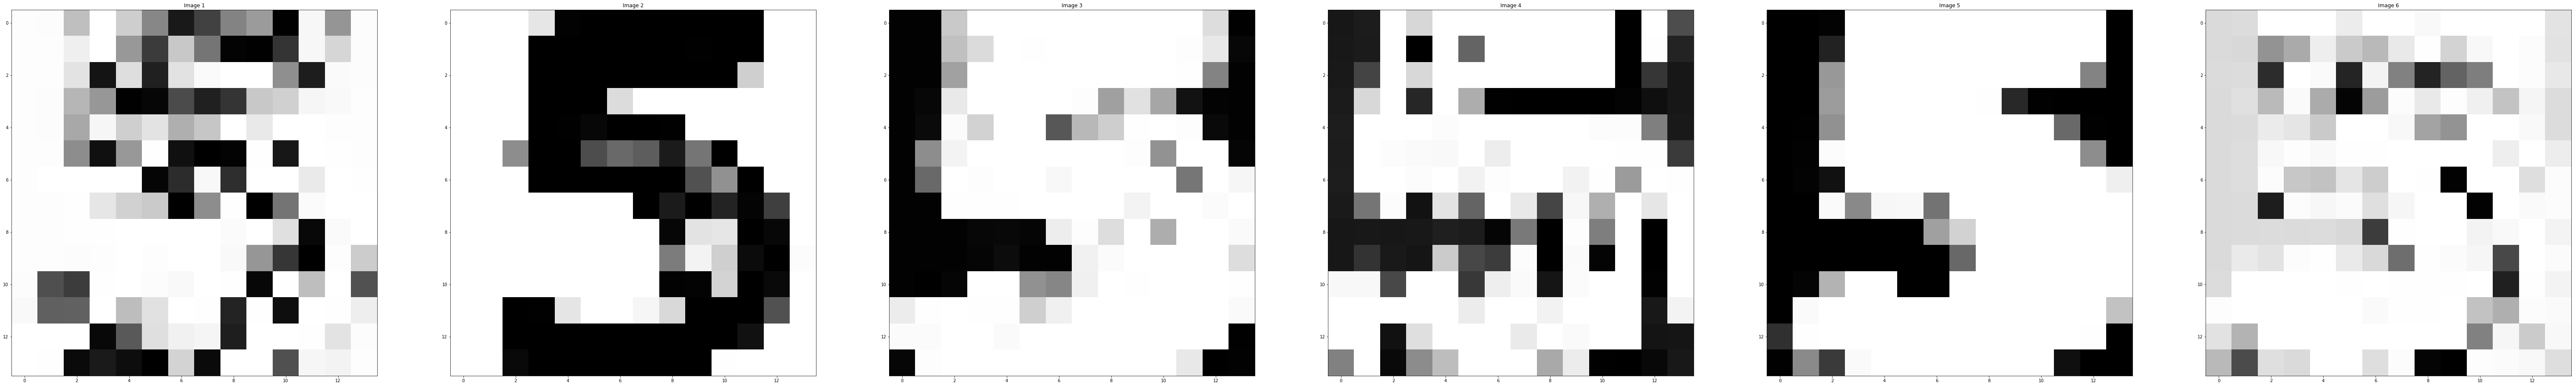


3. Convolution
Output image shape: (10, 10, 16)


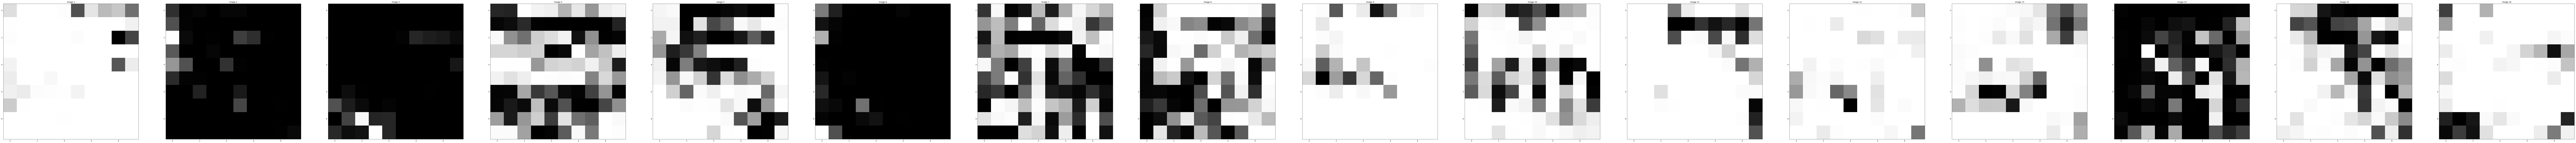


4. Pooling
Output image shape: (5, 5, 16)


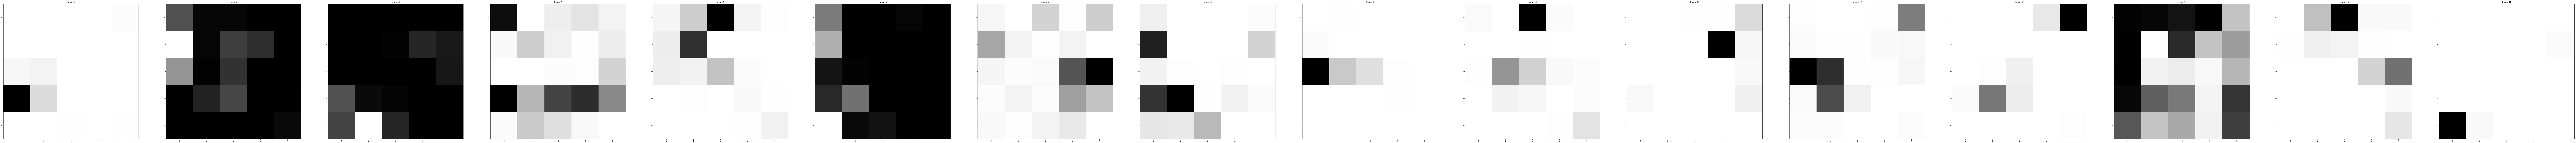


5. Convolution
Output image shape: (1, 1, 120)


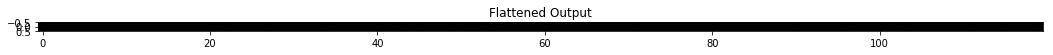


6. Full Connection
Output image shape: 84


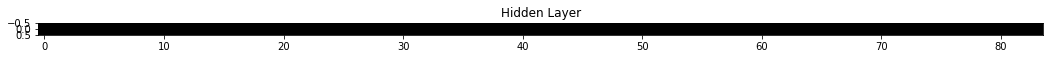


7. Output
Number of output classes: 10


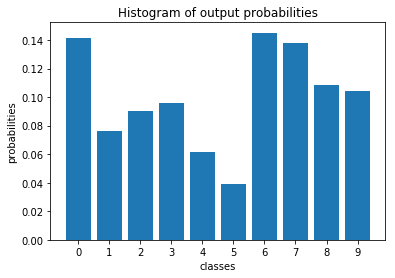



Predicted Class: 6


In [174]:
conv_activation = 'sigmoid'
hidden_activation = 'sigmoid'
output_activation = 'softmax'

cnn_ = Convolutional_Neural_Network( CONV_filter_size, CONV_stride, POOL_filter_size, POOL_stride )

cnn_.read_image(image_path, image_dimensions, normalize=True)

yHat = cnn_.forward(conv_activation, hidden_activation, output_activation)

print '\n\nPredicted Class:', np.argmax(yHat)

### Observations:
1. tanh and sigmoid does not give as good results as relu as they tend to make the output constant if its magnitude is high.
2. sigmoid gives overflow on normal image data but performs well on normalized image.
3. relu gives output as a single class with probability one and others 0.
4. sigmoid and tanh give almost equal probabilities of each class.